In [80]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.svm import LinearSVR,SVR
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pickle

In [30]:
df=pd.read_excel('/content/DS - Assignment Part 1 data set.xlsx')
df.head()

,Transaction date,House Age,Distance from nearest Metro station (km),Number of convenience stores,latitude,longitude,Number of bedrooms,House size (sqft),House price of unit area
0,2012.916667,32.0,84.87882,10,24.98298,121.54024,1,575,37.9
1,2012.916667,19.5,306.59470,9,24.98034,121.53951,2,1240,42.2
2,2013.583333,13.3,561.98450,5,24.98746,121.54391,3,1060,47.3
3,2013.500000,13.3,561.98450,5,24.98746,121.54391,2,875,54.8
4,2012.833333,5.0,390.56840,5,24.97937,121.54245,1,491,43.1


In [31]:
df.tail()

,Transaction date,House Age,Distance from nearest Metro station (km),Number of convenience stores,latitude,longitude,Number of bedrooms,House size (sqft),House price of unit area
409,2013.000000,13.7,4082.01500,0,24.94155,121.50381,3,803,15.4
410,2012.666667,5.6,90.45606,9,24.97433,121.54310,2,1278,50.0
411,2013.250000,18.8,390.96960,7,24.97923,121.53986,1,503,40.6
412,2013.000000,8.1,104.81010,5,24.96674,121.54067,1,597,52.5
413,2013.500000,6.5,90.45606,9,24.97433,121.54310,2,1097,63.9


In [32]:
#checking for null values
df.isnull().sum()

Transaction date                            0
House Age                                   0
Distance from nearest Metro station (km)    0
Number of convenience stores                0
latitude                                    0
longitude                                   0
Number of bedrooms                          0
House size (sqft)                           0
House price of unit area                    0
dtype: int64

In [33]:
#checking for duplicate columns
df.duplicated().sum()

0

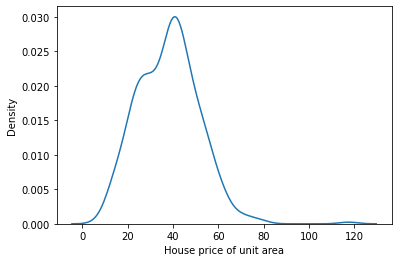

In [34]:
sn.kdeplot(df['House price of unit area'])
plt.show()

In [35]:
print(df['House price of unit area'].describe())

count    414.000000
mean      37.980193
std       13.606488
min        7.600000
25%       27.700000
50%       38.450000
75%       46.600000
max      117.500000
Name: House price of unit area, dtype: float64


In [36]:
print(df['House price of unit area'].mean())
print(df['House price of unit area'].std())
print(df['House price of unit area'].median())
print(df['House price of unit area'])

37.980193236714975
13.606487697735314
38.45
0      37.9
1      42.2
2      47.3
3      54.8
4      43.1
       ... 
409    15.4
410    50.0
411    40.6
412    52.5
413    63.9
Name: House price of unit area, Length: 414, dtype: float64


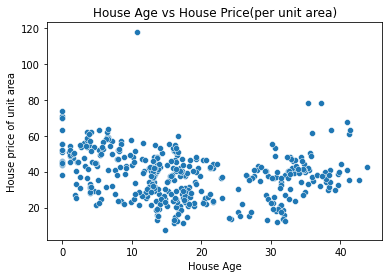

In [37]:
sn.scatterplot(df['House Age'],df['House price of unit area'])
plt.title('House Age vs House Price(per unit area)')
plt.show()

**Observation:**
There is not much relationship of feature **house age** with **house price**.

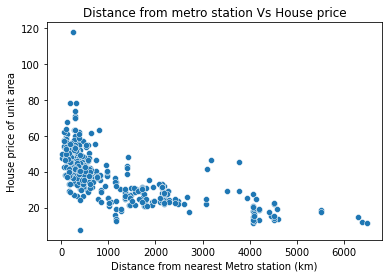

In [38]:
sn.scatterplot(df['Distance from nearest Metro station (km)'],df['House price of unit area'])
plt.title('Distance from metro station Vs House price')
plt.show()

**Observation:** Houses near to metro station are more and costlier.

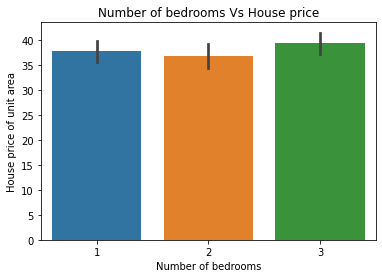

In [39]:
sn.barplot(df['Number of bedrooms'],df['House price of unit area'])
plt.title('Number of bedrooms Vs House price')
plt.show()

**Observation :** Number of bedrooms does not affect much on house price.

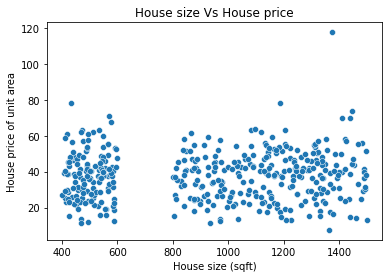

In [40]:
sn.scatterplot(df['House size (sqft)'],df['House price of unit area'])
plt.title('House size Vs House price')
plt.show()

**Observation :** House size also does not afect the price of house alone.

Now lets check the multicollinearity between given features in the dataset. We will remove the features that have Variance inflation factor value greater or equals to 10.

In [10]:
df.columns

Index(['Transaction date', 'House Age',
       'Distance from nearest Metro station (km)',
       'Number of convenience stores', 'latitude', 'longitude',
       'Number of bedrooms', 'House size (sqft)', 'House price of unit area'],
      dtype='object')

In [41]:
data=df[['House Age',
       'Distance from nearest Metro station (km)',
       'Number of convenience stores',
       'Number of bedrooms','House size (sqft)']]

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
    
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = data.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
  
print(vif_data)

                                    feature        VIF
0                                 House Age   3.027382
1  Distance from nearest Metro station (km)   2.112750
2              Number of convenience stores   3.361868
3                        Number of bedrooms  15.648281
4                         House size (sqft)  17.228124


As **House size (sqft)** features has the highest VIF, therefore we will remove **House size (sqft)** feature first.

In [43]:
data.drop(columns='House size (sqft)',inplace=True)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = data.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
  
print(vif_data)

                                    feature       VIF
0                                 House Age  3.025437
1  Distance from nearest Metro station (km)  1.958205
2              Number of convenience stores  3.132211
3                        Number of bedrooms  4.217572


Now all feautures have VIF less than 10, therefore these features will be our final features.

In [44]:
df.drop(columns='House size (sqft)',inplace=True)
df.shape

(414, 8)

# **Train Test Split**

In [59]:
y=df['House price of unit area']
x=df.drop(columns=['Transaction date','House price of unit area'])

In [60]:
x_tr,x_te,y_tr,y_te=train_test_split(x,y,test_size=0.2)

In [61]:
scaler=StandardScaler()
x_tr=scaler.fit_transform(x_tr)
x_te=scaler.transform(x_te)

In [75]:
lr_reg=SGDRegressor()
lg_reg_params={'penalty':['l1','l2'],
               'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100],
               'warm_start':[True,False]}
rcv=RandomizedSearchCV(lr_reg,lg_reg_params,cv=3)
rcv.fit(x_tr,y_tr)

RandomizedSearchCV(cv=3, estimator=SGDRegressor(),
                   param_distributions={'alpha': [1e-05, 0.0001, 0.001, 0.01,
                                                  0.1, 1, 10, 100],
                                        'penalty': ['l1', 'l2'],
                                        'warm_start': [True, False]})

In [76]:
rcv.best_score_

0.550528354516629

In [77]:
lr_reg=rcv.best_estimator_
y_preds=lr_reg.predict(x_te)
print('RMSE :',mean_squared_error(y_te,y_preds,squared=False))

RMSE : 7.518036858982972


In [73]:
xgb=xgboost.XGBRegressor(objective='reg:squarederror')
xgb_params={'max_depth':[2,4,8,16,32],
            'learning_rate':[0.001,0.01,0.1,1,10,100],
            'n_estimators':[2,4,8,16,32,64,128]}
rcv=RandomizedSearchCV(xgb,xgb_params,cv=3)
rcv.fit(x_tr,y_tr)

RandomizedSearchCV(cv=3, estimator=XGBRegressor(objective='reg:squarederror'),
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1, 1,
                                                          10, 100],
                                        'max_depth': [2, 4, 8, 16, 32],
                                        'n_estimators': [2, 4, 8, 16, 32, 64,
                                                         128]})

In [74]:
xgb=rcv.best_estimator_
y_preds=xgb.predict(x_te)
print('RMSE :',mean_squared_error(y_te,y_preds,squared=False))

RMSE : 6.790542948692355


In [78]:
svr=LinearSVR()
svr_params={'C':[0.001,0.1,1,10,100],
            'fit_intercept':[True,False],
            'dual':[True,False]}
rcv=RandomizedSearchCV(svr,svr_params,cv=3)
rcv.fit(x_tr,y_tr)            

RandomizedSearchCV(cv=3, estimator=LinearSVR(),
                   param_distributions={'C': [0.001, 0.1, 1, 10, 100],
                                        'dual': [True, False],
                                        'fit_intercept': [True, False]})

In [81]:
lr_svr=rcv.best_estimator_
y_preds=lr_svr.predict(x_te)
print('RMSE :',mean_squared_error(y_te,y_preds,squared=False))

RMSE : 7.685516416918037


In [83]:
svr=SVR()
svr_params={'gamma':['auto','scale'],
            'C':[0.001,0.01,0.1,1,10,100],
            'epsilon':[0.001,0.01,0.1,1,10]}
rcv=RandomizedSearchCV(svr,svr_params,cv=3)
rcv.fit(x_tr,y_tr)

RandomizedSearchCV(cv=3, estimator=SVR(),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'epsilon': [0.001, 0.01, 0.1, 1, 10],
                                        'gamma': ['auto', 'scale']})

In [84]:
svr=rcv.best_estimator_
y_preds=svr.predict(x_te)
print('RMSE :',mean_squared_error(y_te,y_preds,squared=False))

RMSE : 7.048194806995988


In [86]:
from prettytable import PrettyTable

In [88]:
table=PrettyTable(['Model','Root Mean Squared Error'])
table.add_row(['SGD Regressor','7.52'])
table.add_row(['XGBoost Regressor','6.79'])
table.add_row(['Linear SVR','7.69'])
table.add_row(['RBF SVR','7.05'])
print(table)

+-------------------+-------------------------+
|       Model       | Root Mean Squared Error |
+-------------------+-------------------------+
|   SGD Regressor   |           7.52          |
| XGBoost Regressor |           6.79          |
|     Linear SVR    |           7.69          |
|      RBF SVR      |           7.05          |
+-------------------+-------------------------+


# **Feature Importance**

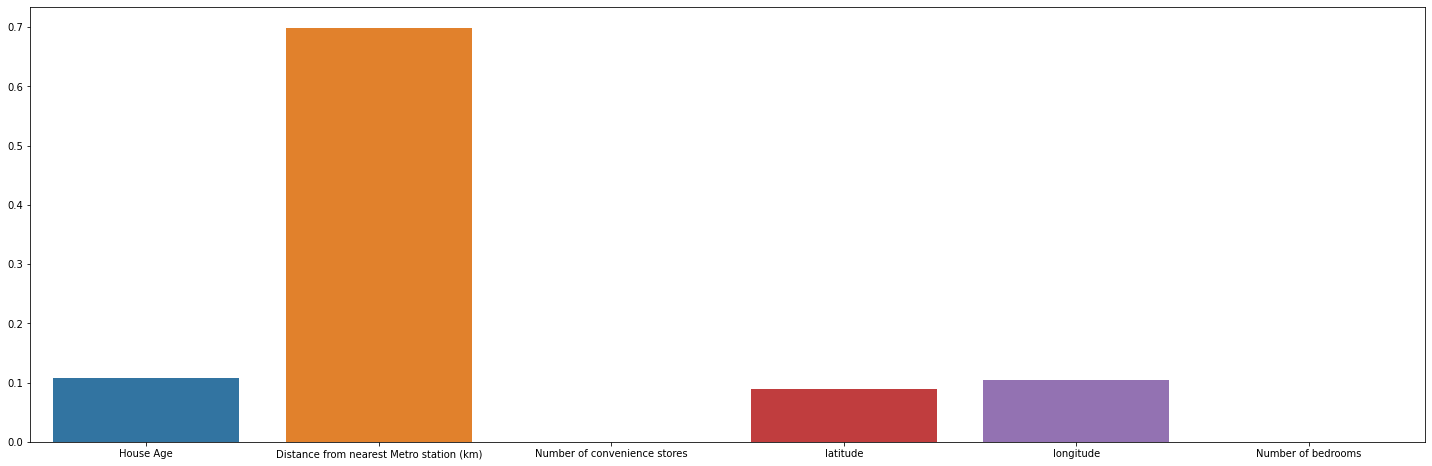

In [97]:
plt.figure(figsize=(25,8))
sn.barplot(x.columns,xgb.feature_importances_)
plt.show()

# Conclusion : 
From the above results we can see, XGBoost Regressor performed the best in the prediction of house prices with least RMSE of **6.79** and the most important feature was the feature '**Distance from nearest Metro station**.'